In [6]:
import warnings

from make_panels import gen_panel, get_mean_panel
import pandas as pd
import dice_ml
from predict_walkaway import WTPGPPredictor

wtp_predictor = WTPGPPredictor(
    model_path="models/gp/runFinalTests_Results_trust-ai-wtp-gp-7ls79_iter1.json"
).load()  # load genetic predictor

out_filename = "counterfactuals.txt"  # output file name (None -> Print to console)
counterfactuals = 5  # amount of counterfactuals generated for each panel
desired_range = (0, 0.05)  # desired walkaway probability range
features_to_vary = ([f'slotcost_{i}' for i in range(1, 31)] +
                    ["expanding_avg_days_to_delivery",
                     "days_since_first_purchase"])  # vary all slotcosts & customer features

def gen_panels(n):
    out = []
    while len(out) < n:
        p = gen_panel(10)[0]
        prob = wtp_predictor.predict(p.get_single_row_df())
        if prob[0] > desired_range[1]:
            out.append(p)
    return out

"""
50 panels, 5 counterf.
1 mean panel, 250 counterf.
some interesting 
"""

panels = gen_panels(5)
data = pd.concat(p.get_single_row_df() for p in panels)
print("panels created")

ref_data = gen_panel(20000)
ref_data = pd.concat(p.get_single_row_df() for p in ref_data)
print("ref data created")
features = list(ref_data.columns)
ref_data["walkaway_probability"] = ref_data.apply(lambda x: wtp_predictor.predict(x), axis=1)

print("data ready")

d = dice_ml.Data(dataframe=ref_data,
                 continuous_features=features,
                 outcome_name='walkaway_probability')

m = dice_ml.Model(model=wtp_predictor,
                  backend='sklearn',
                  model_type='regressor')

exp_random = dice_ml.Dice(d, m, method="random")  # change method to "genetic" for genetic algorithm

#data = data[data["walkaway_probability"] > desired_range[1]]  # only look at panels with too big walkaway prob

panels created
ref data created
data ready


In [7]:
dice_exp_random = exp_random.generate_counterfactuals(query_instances=data,
                                                      total_CFs=counterfactuals,
                                                      desired_range=desired_range,
                                                      features_to_vary=features_to_vary,
                                                      verbose=0,
                                                      # proximity_weight=0.2,  # some hyperparameters for generic algorithm
                                                      # diversity_weight=1.0,  # some hyperparameters for generic algorithm
                                                      )

100%|██████████| 5/5 [00:55<00:00, 11.13s/it]


In [8]:
from make_panels import Panel
import pickle as pkl

out_list = []
if "walkaway_probability" not in data.columns:
    data["walkaway_probability"] = data.apply(lambda x: wtp_predictor.predict(x), axis=1)

for i, counterfacual_df in enumerate(dice_exp_random.cf_examples_list):
    if counterfacual_df.final_cfs_df is None:
        print("no counterf found")
        continue
    
    datapoint = {
        "panel": data.iloc[i].to_frame().T,
        "changes": pd.DataFrame(),
        "new_walkaway_probabilities": []
    }
    
    for j, row in enumerate(counterfacual_df.final_cfs_df.iloc):
        if "walkaway_probability" in row:
            del row["walkaway_probability"]
        row = Panel().load_from_single_row(row).get_single_row_df().iloc[0]  # recalculate median, q1, etc
        diff = row - data.iloc[i]
        if "walkaway_probability" in diff:
            del diff["walkaway_probability"]
        diff = diff[diff != 0]
        
        new_prob = wtp_predictor.predict(row)
        
        datapoint["new_walkaway_probabilities"].append(new_prob)
        datapoint["changes"] = pd.concat([datapoint["changes"], diff.to_frame().T])
        
    out_list.append(datapoint)

with open('data.pkl', 'wb') as handle:
    pkl.dump(out_list, handle, protocol=pkl.HIGHEST_PROTOCOL)

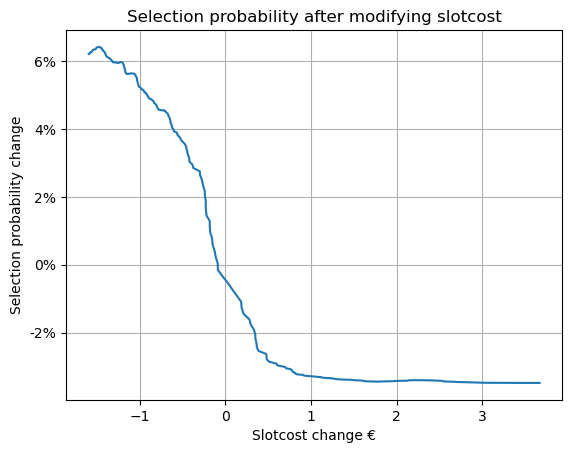

In [197]:

import pickle as pkl
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.4f}'.format

with open('data_mean_panel_250_counterf_selection.pkl', 'rb') as handle:
    all_data: list[dict] = pkl.load(handle)
#print(len(all_data))  # amount of panels
#print(len(all_data[0]["changes"]))  # amount of counterfactuals for each panel
#print(all_data[0].keys())  # for each panel, there is the original panel, changes(counterfactuals), and the new walkaway probabilities after changes
#print(all_data[0]["panel"].columns)  # columns of each panel 

c = dict()
for panel in all_data:
    original_panel: pd.Series = panel["panel"].iloc[0]  # the original panel
    original_walkaway_probability: float = original_panel["walkaway_probability"]  # original panels walkaway probability
    counterfactuals: pd.DataFrame = panel["changes"]  # all counterfactuals for this panel
    new_walkaway_probs: list = panel["new_walkaway_probabilities"]  # walkaway probabilities after applying counterfactuals
    #print(len(counterfactuals))  # amount of counterfactuals for this panel
    #print(original_panel["median_cost"])  # get some feature of panel
    
    for counterfactual_idx in range(len(new_walkaway_probs)):  # look through each counterfactual for this panel
        changes: pd.Series = counterfactuals.iloc[counterfactual_idx]  # the changes that were made
        new_walkaway_prob: float = new_walkaway_probs[counterfactual_idx]  # the new walkaway probability after changes
        
        for i in range(1, 31):
            c1 = f"slotcost_{i}"
            field = f"selection_probability_{i}"
            if c1 in changes:
                if pd.notna(changes[c1]):
                    c[changes[c1]] = c.get(changes[c1], []) + [changes[field]]
        
        # you can get the changed full panel like this (add the changes to the original panel and set the new walkaway prob)
        counterfactual_panel = original_panel.copy(deep=True)
        for name, val in changes.fillna(0).items():
            if name in counterfactual_panel:
                counterfactual_panel[name] += val
        
        #print(selection_probs, sum(selection_probs))
        #print(orig_selection_probs, sum(orig_selection_probs))
        #print(original_panel)
        #print(counterfactual_panel)
        #print(original_panel)
        #print(counterfactual_panel)
        #counterfactual_panel["walkaway_probability"] = new_walkaway_prob
#print(c)
newc = dict()
for k, v in c.items():
    #v = list(x for x in v if x > 0)
    #if not v:
    #    continue
    newc[k] = sum((x) for x in v) / len(v)
newc = sorted(newc.items(), key=lambda x: x[0])
ysmoothed = gaussian_filter1d([float(x[1]) for x in newc], sigma=10)
plt.plot([float(x[0]) for x in newc], ysmoothed)
plt.title("Selection probability after modifying slotcost")
plt.xlabel("Slotcost change €")
plt.ylabel("Selection probability change")
plt.grid()
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.savefig("plt.jpg")
plt.show()

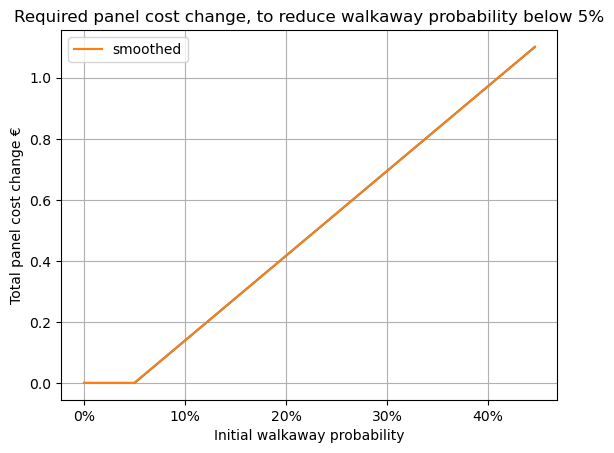

In [195]:
import numpy as np
import pickle as pkl
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
import tqdm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.4f}'.format

from predict_walkaway import WTPGPPredictor
wtp_predictor = WTPGPPredictor(
    model_path="models/gp/runFinalTests_Results_trust-ai-wtp-gp-7ls79_iter1.json"
).load()  # load genetic predictor

with open('data_mean_panel_250_counterf_selection.pkl', 'rb') as handle:
    all_data: list[dict] = pkl.load(handle)
#print(len(all_data))  # amount of panels
#print(len(all_data[0]["changes"]))  # amount of counterfactuals for each panel
#print(all_data[0].keys())  # for each panel, there is the original panel, changes(counterfactuals), and the new walkaway probabilities after changes
#print(list(all_data[0]["panel"].columns))  # columns of each panel 

c = dict()
for panel in all_data:
    original_panel: pd.Series = panel["panel"].iloc[0]  # the original panel
    original_walkaway_probability: float = original_panel["walkaway_probability"]  # original panels walkaway probability
    counterfactuals: pd.DataFrame = panel["changes"]  # all counterfactuals for this panel
    new_walkaway_probs: list = panel["new_walkaway_probabilities"]  # walkaway probabilities after applying counterfactuals
    #print(len(counterfactuals))  # amount of counterfactuals for this panel
    #print(original_panel["median_cost"])  # get some feature of panel
    
    for counterfactual_idx in range(len(new_walkaway_probs)):  # look through each counterfactual for this panel
        changes: pd.Series = counterfactuals.iloc[counterfactual_idx]  # the changes that were made
        new_walkaway_prob: float = new_walkaway_probs[counterfactual_idx]  # the new walkaway probability after changes
        
        for i in range(1, 31):
            c1 = f"slotcost_{i}"
            field = f"walkaway_probability"
            walk_delta = original_walkaway_probability#new_walkaway_prob - original_walkaway_probability
            if c1 in changes:
                if pd.notna(changes[c1]):
                    c[walk_delta] = c.get(walk_delta, []) + [changes[c1]]
        
        # you can get the changed full panel like this (add the changes to the original panel and set the new walkaway prob)
        counterfactual_panel = original_panel.copy(deep=True)
        for name, val in changes.fillna(0).items():
            if name in counterfactual_panel:
                counterfactual_panel[name] += val
        
        #print(selection_probs, sum(selection_probs))
        #print(orig_selection_probs, sum(orig_selection_probs))
        #print(original_panel)
        #print(counterfactual_panel)
        #print(original_panel)
        #print(counterfactual_panel)
        #counterfactual_panel["walkaway_probability"] = new_walkaway_prob
#print(c)
newc = dict()
for k, v in c.items():
    #v = list(x for x in v if x > 0)
    #if not v:
    #    continue
    newc[k] = sum(abs(x) for x in v) / len(v)
newc = sorted(newc.items(), key=lambda x: x[0])
ysmoothed = gaussian_filter1d([float(x[1]) for x in newc], sigma=1)
ysmoothed1 = gaussian_filter1d([float(x[1]) for x in newc], sigma=30)
plt.plot([0, 0.05] + [float(x[0]) for x in newc], [0, 0] + list(ysmoothed))
plt.plot([0, 0.05] + [float(x[0]) for x in newc], [0, 0] + list(ysmoothed1), label="smoothed")
plt.title("Required panel cost change, to reduce walkaway probability below 5%")
plt.xlabel("Initial walkaway probability")
plt.ylabel("Total panel cost change €")
plt.legend()
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])
plt.grid()
plt.savefig("plt.jpg")
plt.show()

In [ ]:
import numpy as np
import pickle as pkl
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
import tqdm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.4f}'.format

from predict_walkaway import WTPGPPredictor
wtp_predictor = WTPGPPredictor(
    model_path="models/gp/runFinalTests_Results_trust-ai-wtp-gp-7ls79_iter1.json"
).load()  # load genetic predictor

with open('data_1000_panels_5_counterf_selection.pkl', 'rb') as handle:
    all_data: list[dict] = pkl.load(handle)
#print(len(all_data))  # amount of panels
#print(len(all_data[0]["changes"]))  # amount of counterfactuals for each panel
#print(all_data[0].keys())  # for each panel, there is the original panel, changes(counterfactuals), and the new walkaway probabilities after changes
print(list(all_data[0]["panel"].columns))  # columns of each panel 

c = dict()
for panel in all_data:
    original_panel: pd.Series = panel["panel"].iloc[0]  # the original panel
    original_walkaway_probability: float = original_panel["walkaway_probability"]  # original panels walkaway probability
    counterfactuals: pd.DataFrame = panel["changes"]  # all counterfactuals for this panel
    new_walkaway_probs: list = panel["new_walkaway_probabilities"]  # walkaway probabilities after applying counterfactuals
    #print(len(counterfactuals))  # amount of counterfactuals for this panel
    #print(original_panel["median_cost"])  # get some feature of panel
    
    for counterfactual_idx in range(len(new_walkaway_probs)):  # look through each counterfactual for this panel
        changes: pd.Series = counterfactuals.iloc[counterfactual_idx]  # the changes that were made
        new_walkaway_prob: float = new_walkaway_probs[counterfactual_idx]  # the new walkaway probability after changes
        
        for i in range(1, 31):
            c1 = f"slotcost_{i}"
            field = f"walkaway_probability"
            if c1 in changes:
                if pd.notna(changes[c1]):
                    c[walk_delta] = c.get(walk_delta, []) + [changes[c1]]
        
        # you can get the changed full panel like this (add the changes to the original panel and set the new walkaway prob)
        counterfactual_panel = original_panel.copy(deep=True)
        for name, val in changes.fillna(0).items():
            if name in counterfactual_panel:
                counterfactual_panel[name] += val
        
        #print(selection_probs, sum(selection_probs))
        #print(orig_selection_probs, sum(orig_selection_probs))
        #print(original_panel)
        #print(counterfactual_panel)
        #print(original_panel)
        #print(counterfactual_panel)
        #counterfactual_panel["walkaway_probability"] = new_walkaway_prob
#print(c)

newc = dict()
for k, v in c.items():
    #v = list(x for x in v if x > 0)
    #if not v:
    #    continue
    newc[k] = sum(abs(x) for x in v) / len(v)
newc = sorted(newc.items(), key=lambda x: x[0])
ysmoothed = gaussian_filter1d([float(x[1]) for x in newc], sigma=40)
plt.plot([float(x[0]) for x in newc], ysmoothed)
plt.title("Required panel cost change, to reduce walkaway probability below 5%")
plt.xlabel("Initial walkaway probability")
plt.ylabel("Total panel cost change €")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])
plt.grid()
plt.savefig("plt.jpg")
plt.show()